# <center> Analysing F1 data to predict Safety car appearances <center/>

The main purpose of this notebook is to analyse F1 data in order to identify the possible patterns of Safety car appearance in F1 in the last seasons. We'll be using two datasets consisting of the race event general information and the dataset with the standings at each race event.

The first analyses will be focused on exploring each dataset. Then, analyses mixing up the features of different datasets would be interesting for spotting apparently underlying behaviors.

## Imports

We basically import libraries for loading, processing and visualizing data.

In [41]:
import sys
print(sys.version)

3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
#import squarify
import pickle
import warnings
from matplotlib.ticker import  MultipleLocator

# Ignore warnings
warnings.filterwarnings("ignore")

# Set visualization style
#sns.set_style('darkgrid')

In [43]:
# Create color palette
c_mako = sns.color_palette("mako", 25, as_cmap=False)
c_flare = sns.color_palette("flare", 25, as_cmap=False)
c_husl = sns.color_palette("husl", 15, as_cmap=False)

## Load data

We load the files of interest. For the file containing the standings, we defined a dictionary that contains the standings through the year for each season. We make sure that the standings are stored as a pandas dataframe object type.

In [ ]:
path = "../Data/"

In [45]:
calendar_df = pd.read_pickle(f'{path}Calendar_info_2018_2023.pkl')

with open(f'{path}Standings_info_2018_2023.pkl', 'rb') as handle:
     standings_gp = pickle.load(handle)
        
for year in range(2018, 2024): 
    standings_gp[year] = pd.DataFrame(standings_gp[year])

## Exploring analysis

First part: analyse and draw hypothesis on the behavior of the data, comments on the patterns etc.

### Calendar 

The data we'll work on was extracted from the Fast-F1 python library and covers the race events from 2018 to 2022. We've added the 2023 season events in order to predict real life events. Information related to race incidents was retrieved from kaggle and wikipedia. The dataset is composed by basic features related to the race event (date, location, circuit, name, etc.), race information (average lap times, race incidents, etc.), and weather conditions on day race (air and track temperature, humidity, rain, etc.).

In [46]:
print(f"Raw dataset size: {calendar_df.shape}"), print(f"Actual dataset size: {calendar_df.dropna(subset = 'Location').shape}")
calendar_df.dropna(subset = 'Location', inplace = True)

Raw dataset size: (138, 24)
Actual dataset size: (126, 24)


In [47]:
calendar_df.iloc[:4,:12]

,Race_number,Date,Location,Circuit_type,EventName,Local_time_start,Season,ToD,Total_laps,Total_distance,Average_lap_time,DNFs
0,1,2018-03-25,Melbourne,Urban,Australian Grand Prix,00:00:00,2018.0,Day,58.0,303.93,0 days 00:01:32.642810344,5.0
1,2,2018-04-08,Sakhir,Roadtrack,Bahrain Grand Prix,00:00:00,2018.0,Day,57.0,305.05,0 days 00:01:36.876140350,3.0
2,3,2018-04-15,Shanghai,Roadtrack,Chinese Grand Prix,06:00:00,2018.0,Day,56.0,303.11,0 days 00:01:42.435357142,1.0
3,4,2018-04-29,Baku,Urban,Azerbaijan Grand Prix,12:00:00,2018.0,Day,51.0,304.41,0 days 00:02:02.044921568,7.0


In [48]:
calendar_df.iloc[:4,12:]

,SC_NumberOfAppearances,SC_TotalLaps,RedFlag,Average_lap_time_minutes,Average_lap_time_seconds,Rain,Average_AirTemp,Average_Humidity,Average_Pressure,Average_TrackTemp,Average_WindDirection,Average_WindSpeed
0,1,2,N,1.0,32.643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,N,1.0,36.876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,N,1.0,42.435,0.0,19.446429,24.089286,1018.131250,37.019643,127.392857,1.837500
3,2,11,N,2.0,2.045,0.0,16.661404,45.651754,1021.913158,25.251754,123.789474,2.222807


Some events are non-nexistent as they occured as a side effect during the retrieval process. To reduce the bias in our analyses, we prefer to not take them into account for evaluating the completeness of the dataset. Hopefully, they represented a low share of the total events.

So... let's get started!

An exploration on the completeness of the dataset shows a relatively high percentage (~17%) of missing values for half of the features. 
Without any further context, we would expect that the missing of key features has a significant negative impact on the quality of the dataset. However, as the 2023 season has just started, it is completely natural to have holes in the dataset: the analysis has shown that, except two rows, all other missing values (20 rows) correspond to the 2023 season. In particular, they are related to variables (weather and race information, race incidents) that are (very) hard to predict accurately at the start of the season. We can, however, notice that variables of the safety car and red flags are not missing, yet they are unknown at the start of the season. This disjointedness is due to how the dataset was constructed and it won't affect the rest of the study as missing rows won't be taken into account. Knowing the context, it seems for us a complete dataset as it suits for the purposes of this study.

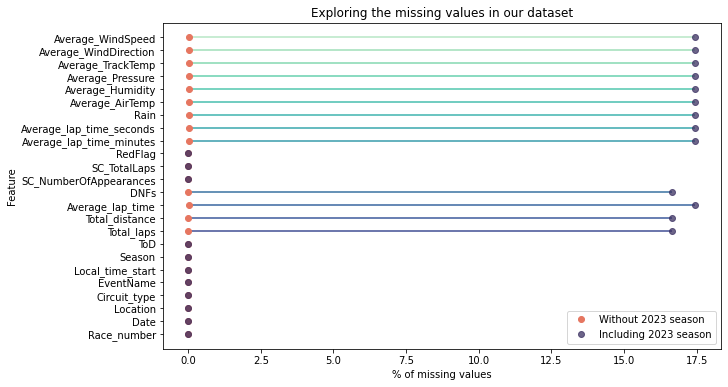

In [175]:
nullval = calendar_df.isnull().sum()
nb_events = len(calendar_df)
nullval_pct = 100*nullval/nb_events

plt.figure(figsize = (10, 6))
plt.hlines(calendar_df.columns, 0, nullval_pct, color = c_mako)
plt.plot(calendar_df.query("Season < 2023").isnull().sum()/(nb_events-23), calendar_df.columns, 'o', color = c_flare[5], \
                            label = 'Without 2023 season')
plt.plot(nullval_pct, calendar_df.columns, 'o', color = c_mako[5], alpha = .75 ,label = 'Including 2023 season')

plt.title("Exploring the missing values in our dataset")
plt.xlabel('% of missing values')
plt.ylabel('Feature')
plt.legend();

A common technique for analysing data is to study the correlation between features. Correlation helps to highlight possible patterns and will be useful for choosing the correct features to build a model. Nevertheless, context is important to establish the limits of correlation. For instance, we assume that on rainy days, there's less grip on track and the pace is slower, however, the correlation between the features **rain** and **average_lap_time** (pace) is low. So, what else are we missing? Well, we need to monitor the evolution of the rain for each race and its real effects on the pace. Also, we see that the appearance of a safety car is correlated to DNFs. However, not every DNF leads to a safety car, and not every safety car is due to a DNF (indeed, they can also appear if there's heavy rain), thus always remember the phrase **correlation does not imply causation**. 



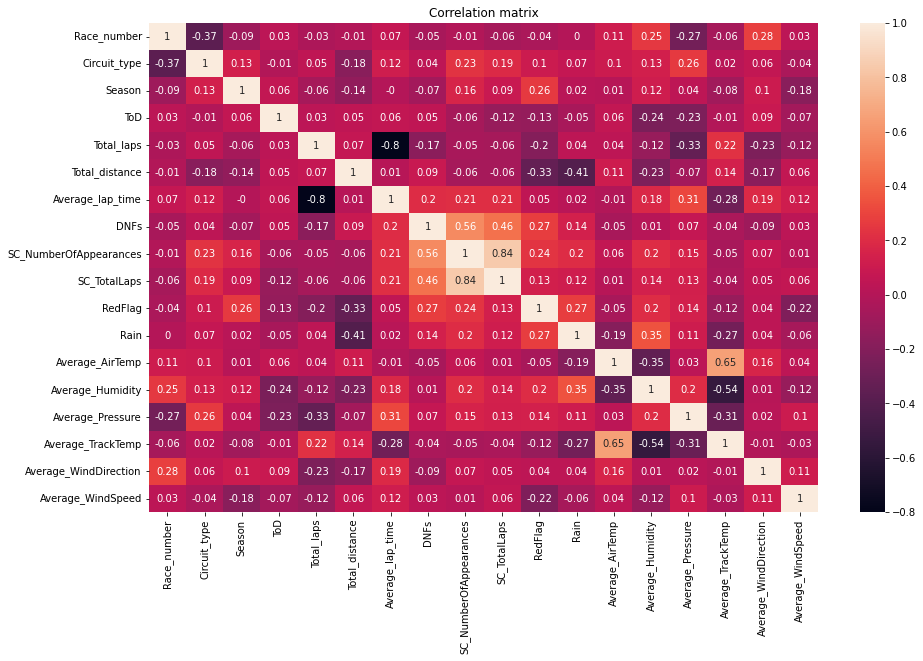

In [50]:
df_ = calendar_df.dropna().copy()
df_['RedFlag'] = df_.RedFlag.apply(lambda x: (x == 'Y')*1)
df_['ToD'] = df_.ToD.apply(lambda x: (x == 'Night')*1)
df_['Circuit_type'] = df_.Circuit_type.apply(lambda x: (x == 'Urban')*1)
df_['Average_lap_time'] = df_.Average_lap_time.apply(lambda x: np.round(x.seconds + x.microseconds*1e-6, 3))
df_['Season'] = df_.Season.apply(int)

plt.figure(figsize = (15, 9))
sns.heatmap(df_.drop(['Average_lap_time_minutes', 'Average_lap_time_seconds'], axis = 1).corr()\
                                                        .apply(lambda x: np.round(x, 2)), annot = True)
plt.title("Correlation matrix");

An overall low correlation between variables is observed. Very few of these correlations are significant: track temperature tends to vary proportionally to air temperature, amongst other variables. Whereas, the quantity of DNFs impacts the occurrence of the safety car, no relevant pattern is really discernible, idem for the total number of laps involving the safety car and frequency of its occurrence (naturally, the more the safety car comes out, the more laps it will run, so it does not add any relevant information to us). This suggests that there are underlying variables that we need to explore in order to further identify potential patterns in the occurrence of a safety car.

The presented variables have a positive correlation, although notable negative correlations also exist: It appears that as lap time increases, the number of laps decreases. The reason behind this lies in the rules, which impose a minimum distance of 305 km to be covered, and that usually varies slightly from one circuit to another. Consequently, a shorter circuit will result in faster times and, equally, more laps will be completed. Also, it can be observed how humidity is one of the factors that impact the track temperature, without it being the primary one.

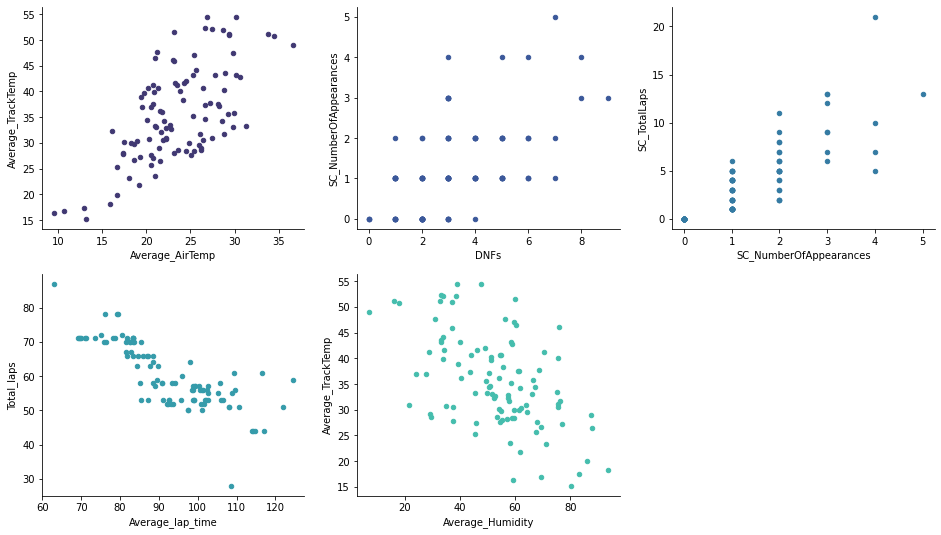

In [51]:
dic_corr = {0: ['Average_AirTemp', 'Average_TrackTemp'], 1: ['DNFs', 'SC_NumberOfAppearances'], \
            2: ['SC_NumberOfAppearances', 'SC_TotalLaps'],  3: ['Average_lap_time', 'Total_laps'], \
            4: ['Average_Humidity', 'Average_TrackTemp']}

figure, axes = plt.subplots(2, 3, figsize = (16, 9))
axes.flat[-1].set_visible(False)

for i in range(5):
    ax = axes.flatten()[i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    df_.plot.scatter(x = dic_corr[i][0], y = dic_corr[i][1], color = c_mako[3*(i+2)], ax = ax)

Other pairs of variables can be of interest for further study, although their correlation is weak and they do not provide relevant information for achieving our objectives. For this reason, we will not enter into any further details. Such variables are: 

- Rain / Total distance
- Red Flag / Total distance
- Rain / Average Humidity
- SC Total Laps / SC Number of Appearances
- Lap time / Average Pressure
- Total Laps / Average Pressure

Since outliers (from various sources) might cause substantial bias in the analysis of the dataset, using the median rather than the average may be more effective in limiting the impact of outliers. Therefore  we will consider using box plots in order to understand the impact of outliers and gain insight into the current distribution of the data points.

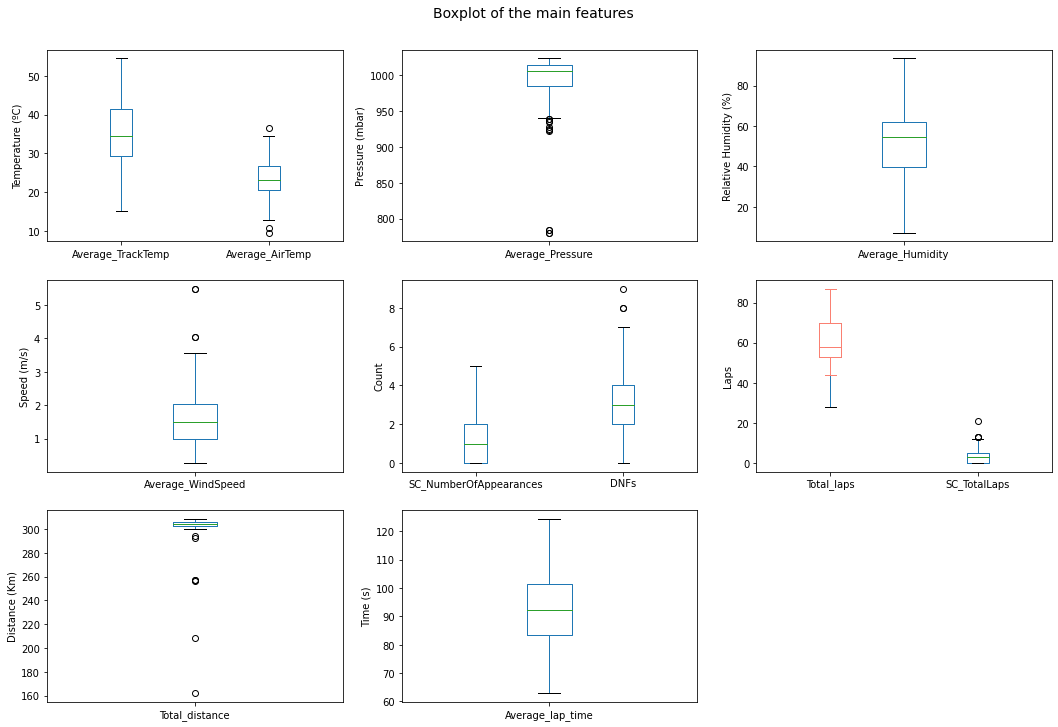

In [52]:
plt.figure(figsize = (18, 12))
plt.suptitle('Boxplot of the main features', fontsize = 14, y = 0.93)
plt.subplot(3, 3, 1)
df_[['Average_TrackTemp', 'Average_AirTemp']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Temperature (ºC)')
plt.subplot(3, 3, 2)
df_[['Average_Pressure']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Pressure (mbar)')
plt.subplot(3, 3, 3)
df_[['Average_Humidity']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Relative Humidity (%)')
plt.subplot(3, 3, 4)
df_[['Average_WindSpeed']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Speed (m/s)')
plt.subplot(3, 3, 5)
df_[['SC_NumberOfAppearances', 'DNFs']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Count')
plt.subplot(3, 3, 6)
df_[['Total_laps', 'SC_TotalLaps']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Laps')
df_.query("Total_laps > 30")[['Total_laps']].boxplot(rot = 0, vert = True, grid = False, color = 'salmon')
plt.xticks([1, 2], ['Total_laps', 'SC_TotalLaps']) # correct the label of the boxplots
plt.subplot(3, 3, 7)
df_[['Total_distance']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Distance (Km)')
plt.subplot(3, 3, 8)
df_[['Average_lap_time']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Time (s)')
plt.show()

Once analysed the box plots of the non-binary variables, we have summarized the information and presented it below. To better outline the particularities of each variable, we have also drew information from the above-mentioned correlation matrix.

- Both **average track temperature** and **air temperature** are distributed symmetrically, wich denotes a distribution of the temperature close to the gaussian distribution. In addition, the temperature of the track is on average higher than air temperature by around 12ºC for the median. The outliers are spotted for air temperature are few and their impact is not meaningful. 

- The distribution of the **average pressure** at each event has a negative skew, denoting a large number of events with a mean pressure ranging from 1006.12 mbar to 1023.13 mbar. We can also notice the presence of what it could seem outliers, however, after a quick check, we can discard the idea of these being anomalies. Instead, we're looking at values of pressure distant from the median and which in terms of location make sense. Therefore, the plot seems to agree with reality, as the events take place in different places in the world. (⚠ *1 mbar = 1 hPa, 1013 mbar = 1 atm*)

- As for the **average humidity**, it's interesting to notice that 25% of the races had been in humid environments (> 60% of humidity). It is worth to mention the 2021 Turkish GP race event, where an impressive rate of 93.5% of average humidity was achieved without any presence of rain, increasing driving difficulty. On the other hand, a similar amount of races had been in dry environments (< 40% of humidity), where the 2022 Spanish GP outsands as the event was held with an average humidity rate of 7.1% in a very hot day (an average air temperature of 36.6ºC and track temperature of 49ºC).


- In general, the **average wind speed** is low (a median of 1.5 m/s ~ 5.4 km/h) for most of the events. There's an appreciable variation of the average wind speed for 25% of the events. It's also important to note that the outliers match wind speeds wich are significant enough to impact the course of the race.

- In most of races, the **presence of safety car** is minimal, as 75% of the races account for 2 or less appearances. In the remaining 25%, the number of appearances spans between 3 and 5, meaning hectic races and in some cases with rain being involved in it.

- A particular attention should be brought to **DNFs**, as for 50% of the race events there's at least 3 DNFs. GP events with 8+ DNFs are unusual and correspond to races involving a strong presence of the safety car, for instance the 2020 Austrian GP and, recently, the 2023 Australian GP.

- The median of **completed laps** per event is 58 with also a high variance being appreciated. Surprisingly, red flags have no real influence on the completed laps for the last 5 seasons, as only two races were shortened because of it: the 2021 Belgian GP and the 2022 Japanese GP. We can observe a limitation in this box plot as the lower bound is associated to what is actually an outlier (the 2022 Japanese GP). It's important to note that the 2021 Belgian GP is not considered here as it was removed during cleansing due to the missing of important values. Therefore, the actual lower bound is established at 44 laps, as shown in the corrected box plot.

- Generally speaking, the **safety car** only lasts a very few laps: in 75% of the events, the amount of laps completed under the safety car is less or equal to 5. However, in hectic races, the safety car often appears several times, thereby extending the number of laps completed under it to a noticeable extent.


- Anomalous values difficult the good readability of the box plot for the **total distance covered**. These values correspond to races disrupted by red flags, with one exception being the Monaco gp race circuit, where the distance covered is 257 km (officially 260.286 km). Considering these factors, normal values for the rest of the circuits range from 300 - 315 km, keeping the races fairly uniform in distance. (⚠ *The term uniform here does not refer to the proper mathematical definition.*) 

- The box plot of the **average lap time** is symmetric, presenting what could be a normal distribution of the lap times. The median of the average lap time is around 92s or 1 min 32s, with a fairly high variance. Surprisingly, the average lap time is not influenced by the presence of rain (as shown in the correlation matrix). However, the presence of the safety car tends to impact the average lap times in a lesser way as for most of times, it's only deployed for a few laps.

Since the presence of rain has an incidence on lap times, we have opted to present such influence through the graph below. It is apparent that lap times in wet conditions are considerably slower compared to those in the dry, apart from those races where there is more than one appearance of the safety car.

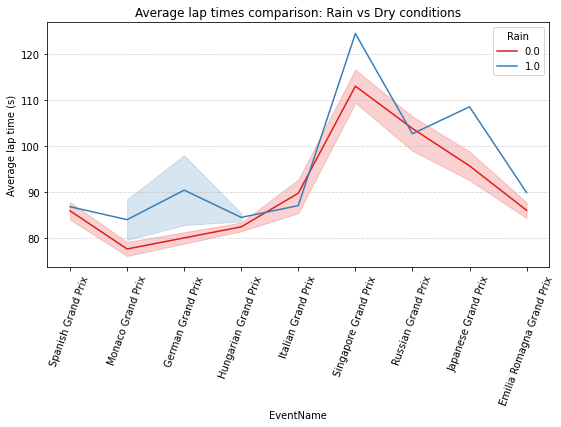

In [53]:
plt.figure(figsize = (9, 4.5))
sns.lineplot(df_[df_.EventName.apply(lambda x: x in df_.query("Rain == 1").EventName.unique())], x = 'EventName', \
             y = 'Average_lap_time', hue = 'Rain', palette = "Set1")

plt.title('Average lap times comparison: Rain vs Dry conditions')
plt.ylabel('Average lap time (s)')
plt.xticks(rotation = 70)
plt.grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .5)
plt.show()

In any case, the discrepancy between the chart and the correlation matrix proves the need for a different approach to estimate the correlation of a binary variable, either natural (e.g. circuit type, red flag) or artificial (e.g. rain, time of the day), and a continuous variable.

Moving on with our analysis, we have chosen to plot the occurrences of the binary variables in order to measure the possible impact on other relevant racing parameters, such as lap times, the number of DNFs and, foremost, the interventions of the safety car.
First, a clear pattern emerges for the majority of the events: in daytime, rain-free conditions, absence of red flags, and on traditional circuits. Moreover, if we exclude the circuit type, almost 90% of the races share this common pattern. 

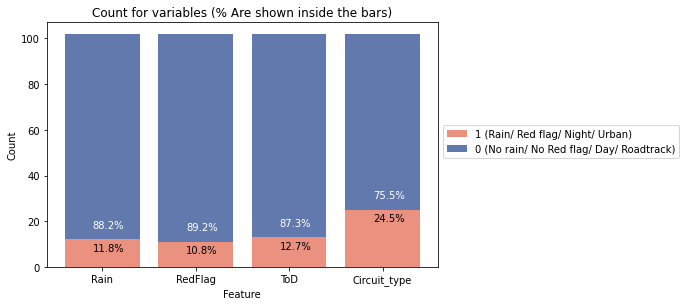

In [54]:
plt.figure(figsize = (7, 4.5))
for feature in ['Rain', 'RedFlag', 'ToD', 'Circuit_type']:
    bp = plt.bar([feature], df_[feature].sum(), color = c_flare[5], alpha = .8)
    pcgt = np.round(df_[feature].sum()/len(df_)*100, 1)
    plt.text(x = bp[0].get_x() + 0.3, y = df_[feature].sum() - 5, s = f"{pcgt}%", color = 'black')
    plt.bar([feature], len(df_) - df_[feature].sum(), bottom = df_[feature].sum(), color = c_mako[9], alpha = .8)
    plt.text(x = bp[0].get_x() + 0.3, y = df_[feature].sum() + 5, s = f"{np.round(100 - pcgt, 2)}%", color = 'white')
    plt.legend(['1 (Rain/ Red flag/ Night/ Urban)', '0 (No rain/ No Red flag/ Day/ Roadtrack)'], bbox_to_anchor = (1, 0.6))

plt.title('Count for variables %s'%('(% Are shown inside the bars)'))
plt.ylabel('Count')
plt.xlabel('Feature');

Then, to what extent can these binary variables eventually impact the outcome of the above-mentioned racing parameters?

In this case, a good idea consists to compare, in quantitative terms, the outcome of racing parameters when the input value is 1, to the outcome of 0. For instance, if we want to evaluate the incidence of rain over the occurrence of a safety car, we can compare its frequency when it rains to when there is no rain. Considering such results and also the proportion of instances of value 1 ( see the figure above), we can then determine how much impact this variable has.

Using this strategy, it can be seen here that for DNFs, the ratio of DNFs when the value of each variable (Rain, RedFlag, ToD, Circuit_type) is 1 is basically the same as the proportion of instances of value 1 over the total number of instances, which means that all these variables have no significant impact on DNFs. In other words, holding a race under these circumstances will not result in a direct increase in DNFs.

For safety car deployments, however, there is a more evident influence of rain and the appearance of red flags, since they account for about 20% of the safety car deployments, while their proportion is slightly above 10%. In the same way, racing in street circuits also increases the risk of a safety car occurring, considering that one third of safety car deployments can be observed in these type of circuits. Her, the time of day hardly affects the deployment of a safety car.

When it comes to the stoppage of races with red flags, it is clear that the rain has a major effect, as 36% of the races that have been interrupted have been due to precipitation, whereas it usually rains only 1 out of 10 races. To a less significant extent than rain, yet still relevant, it can be pointed out how the type of racetrack affects racing, especially since 36% of the disrupted races were held on urban circuits. Finally, we also notice that no night race was interrupted, suggesting that time of the day plays a key role in the occurrence of red flags.

Finally, to study their impact on average lap times, we have set a comparison between the overall mean of average lap times for each circuit where the value of the instance is equal to 1 versus the mean of the lap times where the instance is 0. Thus, it can be seen how lap times increases slightly under rain. Yet, previous analyses have shown how rain has a greater incidence on the lap times than what is indicated here. 
For the other variables, the display of red flags (+2.2s) and the time of the day do clearly show a considerable influence in the performance. Hence, while the time of day is not a parameter that has an impact on the presence of accidents/DNFs/safety car, it certainly has an indirect incidence in the weather conditions of the race and subsequently in other factors that are not considered in this dataset (tire selection, strategy, etc.) and can be observed in terms of average lap times (+2.3s slower at night). As well, street circuits tend to be slower in terms of race pace (+3.7s on average), evidencing the relevance of this particular factor.


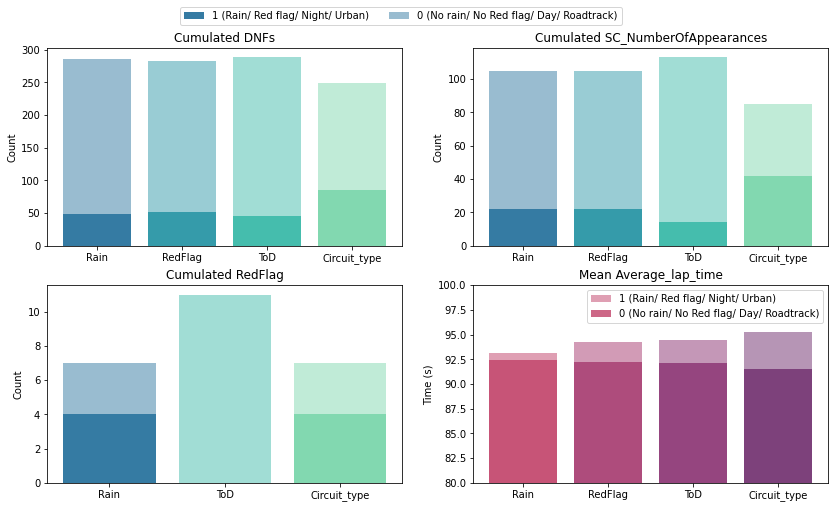

In [55]:
plt.figure(figsize = (14, 8))
for idx, rc_parameter in enumerate(['DNFs', 'SC_NumberOfAppearances', 'RedFlag', 'Average_lap_time']):
    plt.subplot(2, 2, idx + 1)
    for i, factor in enumerate(['Rain', 'RedFlag', 'ToD', 'Circuit_type']):
        if rc_parameter != 'Average_lap_time':
            if rc_parameter == factor:
                next
            else:
                bp = plt.bar([factor], df_.query(f"{factor} == 1")[rc_parameter].sum(), color = c_mako[3*(i+4)])
                bp_ = plt.bar([factor], df_.query(f"{factor} == 0")[rc_parameter].sum(), color = c_mako[3*(i+4)], alpha = .5)
                #pcgt = np.round(df_.query(f"{factor} == 1")[rc_parameter].sum()/df_[rc_parameter].sum()*100, 1)
                #plt.text(x = bp[0].get_x() + 0.3, y = df_.query(f"{factor} == 1")[rc_parameter].sum() - 5/max(df_[rc_parameter]), \
                #                                                         s = f"{pcgt}%", color = 'white')
                #plt.text(x = bp[0].get_x() + 0.3, y = df_.query(f"{factor} == 1")[rc_parameter].sum() + 5/max(df_[rc_parameter]), \
                #                                                         s = f"{np.round(100 - pcgt, 2)}%", color = 'black')    
        else:
            bp = plt.bar([factor], df_.query(f"{factor} == 1")[rc_parameter].mean(), color = c_flare[3*(i+4)], alpha = .5)
            bp_ = plt.bar([factor], df_.query(f"{factor} == 0")[rc_parameter].mean(), color = c_flare[3*(i+4)], alpha = .8)
            
            plt.legend(['1 (Rain/ Red flag/ Night/ Urban)', '0 (No rain/ No Red flag/ Day/ Roadtrack)'])
            plt.ylim((80, 100))
            
    plt.title(f"Cumulated {rc_parameter}" if rc_parameter != 'Average_lap_time' else f"Mean {rc_parameter}")
    #plt.xlabel('Factor')
    plt.ylabel("Count" if rc_parameter != 'Average_lap_time' else "Time (s)")
    
plt.figlegend(['1 (Rain/ Red flag/ Night/ Urban)', '0 (No rain/ No Red flag/ Day/ Roadtrack)'], bbox_to_anchor = (0.70, 0.96), ncol = 2)    
plt.show()

### Standings

The next step of our study focuses on the qualifying and race results for each race event between 2018 and 2022. Datasets were extracted from the Fast-F1 python library and they consist of information such as the laps completed, pilot and team standings after the race or the cause of a DNF among others. The datasets were separated and stored in a dictionary, in form of dataframes for each season, so they could be accessed more easily.

⚠ *Considering that until 2021 sprint races did not exist, and for the sake of a comprehensive study, results of these events will not be included as they do not provide any relevant information for our analysis: the strategies are different than usual, separate qualifying, shorter in duration and as a result more paced races, making them in practice separate events.*

While reviewing the datasets, we spot an anomaly: sometimes, the main drivers fall sick and they are replaced by another driver from their team (generally the so called *third or reserve driver*). So, when a race is completed, the main driver doesn't appear in the table, and this originates a mismatch when the data is retrieved and gathered together, as it causes the data of the absent driver to be inaccessible for that event, including their place in the standings. This also affected the teams standings as they were computed according to the information of the race. Fortunately, this only happened only a few times and the easier way to fix it is to update the mismatching standings for the team, and then gather all dataframes into a single one.
In addition, we'll create a new variable to indicate if a car did complete or not (DNF) the race.

In [423]:
to_rename = {'Alfa Romeo Racing': 'Alfa Romeo', 'Alfa Romeo Racing-Ferrari': 'Alfa Romeo', 'Alfa Romeo-Ferrari': 'Alfa Romeo',\
    'AlphaTauri-Honda': 'AlphaTauri', 'AlphaTauri-RBPT': 'AlphaTauri', 'Alpine-Renault': 'Alpine', \
    'Aston Martin Aramco-Mercedes': 'Aston Martin', 'McLaren-Mercedes': 'McLaren', 'Racing Point-BWT Mercedes': 'Racing Point',\
    'Red Bull Racing-Honda': 'Red Bull Racing'}

for year in range(2018, 2023):
    # Adding DNF
    standings_gp[year]['DNF'] = standings_gp[year].Status.apply(lambda x: 1 - int( x == 'Finished' or 'Lap' in x or 'lap' in x))
    # Unique type
    standings_gp[year]['GridPosition'] = standings_gp[year].GridPosition.apply(int)
    standings_gp[year]['Laps_completed'] = standings_gp[year].Laps_completed.apply(int)
    # Rename constructors name
    standings_gp[year]['TeamName'] = standings_gp[year].TeamName.apply(lambda x: to_rename[x] if x in to_rename else x)
    
    
standings_gp[2020]['Team_standings'].loc[307] = standings_gp[2020].loc[306].Team_standings
standings_gp[2020]['Team_standings'].loc[320] = standings_gp[2020].loc[319].Team_standings
standings_gp[2020]['Team_standings'].loc[333] = standings_gp[2020].loc[335].Team_standings

# Gathering all dataframes into a single one
standings_all = pd.concat([pd.concat([ pd.DataFrame({'Season': len(standings_gp[year])*[year]}), standings_gp[year]], axis = 1)\
                           for year in range(2018, 2023)])

standings_all['Position'] = standings_all.Position.apply(int)
standings_all['GridPosition'] = standings_all.GridPosition.apply(int)

In [62]:
# Team Colors
c_team = {'Ferrari': '#DC0000', 'Mercedes': '#00D2BE', 'Red Bull Racing': '#0600EF', 'McLaren': '#FF8700', 'Renault': '#FFF500',
    'Force India': '#E596C8', 'Sauber': '#DE3146', 'Williams': '#005AFF', 'Toro Rosso': '#5600EF' , 'Haas F1 Team': '#AEAEAE',
       'Racing Point': '#F596C8', 'Alfa Romeo': '#9B0000', 'AlphaTauri': '#2B4562', 'Aston Martin': '#006F62',
       'Alpine': '#0090FF'}

A quick analysis of the completeness of the dataset shows that there are no missing values and that the dataset is therefore complete.

In [57]:
pd.DataFrame(standings_all.isnull().sum(), columns = ['Missing values']).T

,Season,Race_number,Abbreviation,TeamName,Position,GridPosition,Status,Points,Laps_completed,Team_points,Pilot_standings,Team_standings,DNF
Missing values,0,0,0,0,0,0,0,0,0,0,0,0,0


We will first be interested in the evolution of the driver and team standings for the last few seasons. That may bring us insights that can be very useful later on. After all, the closer the standings are (especially at the top), the greater the risks that drivers and teams take, which result in higher chances of going off-track, crashing or having mechanical failures.
To illustrate this point, we take the 2021 British Grand Prix and the 2021 Italian Grand Prix as example, where the actions of the drivers, in a context of intense competition, led to accidents that caused the deployment of the safety car.

Note that in some races, the main driver does not compete, and is replaced by a reserve driver, hence he is not included in the race summary, just as the reserve driver is not included in all the other races. Then, if we count on the raw race summaries, we will not be able to correctly compute automatically all the points of every driver who has participated in the championship. 
To make this task easier we have introduced a function to let us know for every race which drivers have raced, where they are ranked in the championship and for which team they have raced, information that is especially relevant for keeping track of the reserve drivers. Moreover, for easy manipulation, the output is provided in the form of a dictionary.

In [58]:
def get_standings(df, season):
    drivers_list = df[season].Abbreviation.unique()
    standings = {n_race: {} for n_race in df[season].Race_number.unique()}
    for n_race in df[season].Race_number.unique():
        standings[n_race]['EventName'] = calendar_df.query("Season == @season & Race_number == @n_race").iloc[0].EventName
        standings[n_race]['Drivers'] = {driver: {} for driver in drivers_list}
        for driver in drivers_list:
            standings[n_race]['Drivers'][driver]['Participation'] = driver in df[season].\
                                                                    query("Race_number == @n_race").Abbreviation.tolist()
            if standings[n_race]['Drivers'][driver]['Participation']:
                standings[n_race]['Drivers'][driver]['Points'] = df[season].\
                        query("Race_number == @n_race & Abbreviation == @driver").iloc[0].Pilot_standings
                standings[n_race]['Drivers'][driver]['TeamName'] = df[season].\
                        query("Race_number == @n_race & Abbreviation == @driver").iloc[0].TeamName

            elif not standings[n_race]['Drivers'][driver]['Participation'] and n_race == 1:
                standings[n_race]['Drivers'][driver]['Points'] = 0.
                standings[n_race]['Drivers'][driver]['TeamName'] = np.nan
                
            else:
                standings[n_race]['Drivers'][driver]['Points'] = standings[n_race - 1]['Drivers'][driver]['Points']
                standings[n_race]['Drivers'][driver]['TeamName'] = standings[n_race - 1]['Drivers'][driver]['TeamName']

        tmp_standing = pd.DataFrame(standings[n_race]['Drivers']).T.sort_values(by = ['Points', 'Participation'], ascending = False)
        for driver in drivers_list:
            standings[n_race]['Drivers'][driver]['Ranking'] = np.where(tmp_standing.index == driver)[0][0] + 1

    return standings        

An interesting way to observe the progress in the standings, besides monitoring the scores, is to compare the evolution of the average and median scores (in the standings) after each race, which will reveal the levels of disparity between top teams and less competitive teams. Additionally, we will monitor the variation in the point gap between the top two performers in each championship (driver's and constructor's) to understand whether a championship has been competitive or if it has had a clear dominator.

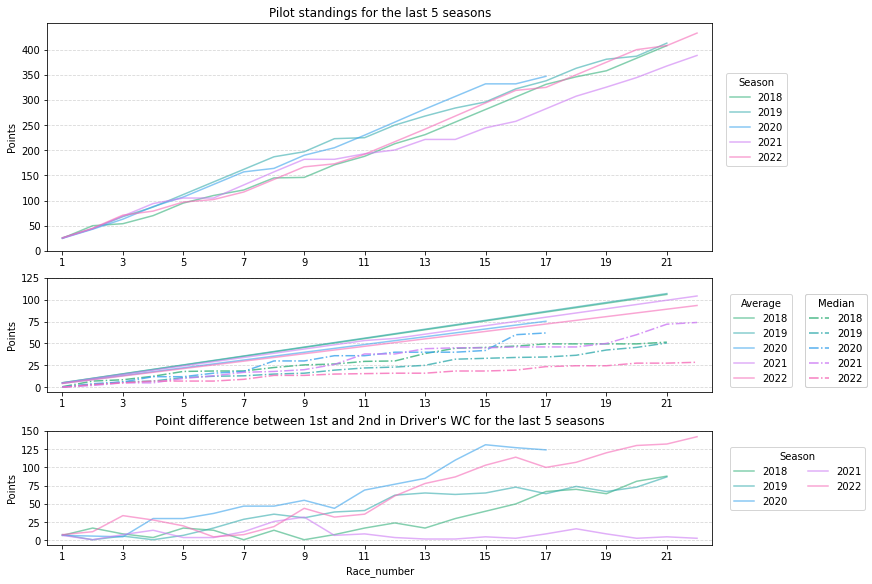

In [59]:
fig, ax = plt.subplots(3, 1, figsize = (12, 8), gridspec_kw={'height_ratios': [2, 1, 1]}, layout='constrained')

for i, season in enumerate(range(2018, 2023)):
    standings = get_standings(standings_gp, season)
    leader, second, last = {'Driver': [], 'Points': []}, {'Driver': [], 'Points': []} , {'Driver': [], 'Points': []}
    avg = []
    med = []
    for n_race in standings.keys():
        temp_df_race = pd.DataFrame(standings[n_race]['Drivers']).T
        leader['Driver'].append(temp_df_race.query("Ranking == 1").index[0])
        leader['Points'].append(temp_df_race.query("Ranking == 1").iloc[0].Points)
        second['Driver'].append(temp_df_race.query("Ranking == 2").index[0])
        second['Points'].append(temp_df_race.query("Ranking == 2").iloc[0].Points)
        last['Driver'].append(temp_df_race.sort_values(by = 'Ranking', ascending = False).index[0])
        last['Points'].append(temp_df_race.sort_values(by = 'Ranking', ascending = False).iloc[0].Points)
        avg.append(temp_df_race.Points.mean())
        med.append(temp_df_race.Points.median())

    p1 = np.array(leader['Points'])
    p2 = np.array(second['Points'])
    p20 = np.array(last['Points'])

    #ax[0].fill_between(standings.keys(), p1, p20, color = c_husl[6+2*i], alpha = 0.8 - i*0.15, label = season)
    ax[0].plot(standings.keys(), p1, color = c_husl[6+2*i], alpha = .6, label = season)
    ax[1].plot(standings.keys(), avg, color = c_husl[6+2*i], alpha = .6, label = season)
    ax[1].plot(standings.keys(), med, color = c_husl[6+2*i], alpha = .8, linestyle = 'dashdot', label = season)
    ax[2].plot(standings.keys(), p1-p2, color = c_husl[6+2*i], alpha = .6, label = season)
    
ax[0].set_title('Pilot standings for the last 5 seasons')
ax[2].set_title("Point difference between 1st and 2nd in Driver's WC for the last 5 seasons", fontsize = 12)
ax[2].set_xlabel('Race_number')

params = [(100*np.round(max(p1)/100)+25, 50), (100*np.round(max(avg)/100)+30, 25), (max(p1-p2)+25, 25)]
for i in range(3):
    ax[i].set_ylabel('Points')
    ax[i].grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .5)
    ax[i].set_xlim(0.5, 22.5, 2)
    ax[i].set_yticks(np.arange(0, params[i][0], params[i][1]))
    ax[i].set_xticks(np.arange(1, 23, 2))
    
ax[0].legend(title = 'Season', bbox_to_anchor=(1.12, .8))
lines = ax[1].get_lines()
legend1 = ax[1].legend([lines[i] for i in range(0, 10, 2)], [lines[i].get_label() for i in range(0, 10 ,2)], \
                       bbox_to_anchor=(1.02, .9), title = 'Average')
legend2 = ax[1].legend([lines[i] for i in range(1, 11, 2)], [lines[i].get_label() for i in range(1, 11, 2)], \
                       bbox_to_anchor=(1.24, .9), title = 'Median')
ax[1].add_artist(legend1)
ax[1].add_artist(legend2)
ax[2].legend(ncol = 2, loc = 'upper left', title = 'Season', bbox_to_anchor=(1.02, .9))

plt.show()

We first notice that, due to the coronavirus pandemic, the 2020 season was shortenned (17 races). 
On the score side, we notice how the championship leader has practically the same points over the first 5 races of the championship, regardless of the season, as also happens over the last third of the season for the 2018, 2019 and 2022 seasons. Here, we exclude the 2020 season since there aren't enough races to do such comparison. Interestingly, the 2021 season doesn't follow the same pattern in the last third of the season, which could be an indicator of a more competitive season.

Looking at the average score, there is a linear upward trend (this is normal since the scoring system is basically *identical$^{1}$*), that doesn't differ significantly from one season to another. The difference is basically the number of (all) participants during the season, in other words, if there are more reserve pilots that have raced, the average score will be lower. In this context, the mean alone does not provide any relevant information, so we will next focus on the median.
Looking at the median, the evolution of the score (median) over the first third of the season appears to be uniform among all the seasons. Moreover, in this context, it can be interpreted how every year mid-tier teams begin with the same handicap against the frontrunners. This period of the year is also when, besides the 2020 season, the median is closer to the average, suggesting therefore that drivers contending for the leading positions in the championship haven't yet accumulated the majority of points.
However, as the championship progresses, an increasing gap between the average and the median indicates a very significant mismatch between the number of points scored by the higher ranked drivers and the number of points scored by the mid-lower ranked drivers. Interestingly, the gap starts to widen when significant improvements to the cars are introduced (from the 6th race onwards), with the front-running teams, and consequently their drivers, benefiting from this. 
There are two exceptions in the 2020 and 2021 seasons, where an increase in the median is noticed during the last stage of the season, showing that the mid-zone teams have managed to regularly score points.

Thirdly, we compare the variation in the differential of points between the top positions in the drivers' championship. 
What emerges first is the heterogeneity of the curves, i.e. there's no established pattern with respect to the above-mentioned variation. Except for 2020, the gap between drivers remains under 50 points until the halfway stage of the season (11th race). 
In 2018, 2019, 2021 and 2022, a change or multiple shifts in leadership occurred in this first half of the season, reflecting a great level of competitiveness, that is needed to keep the championship alive.
Nevertheless, only in 2021, the championship remains competitive until the very last race. 
In contrast, in 2020, we encounter an uncontested domination of the championship leader (Hamilton) throughout the entire season. 
The 2022 season is at least curious, since at the beginning it seemed that one driver (Leclerc) would dominate, but then came a change of leadership in the 6th race and from then on, the new leader of the championship (Verstappen), dominated over the second half of the season.

*$^{1}$Since 2019, an extra point is awarded to the fastest race lap setter, provided he finishes in the top 10.*

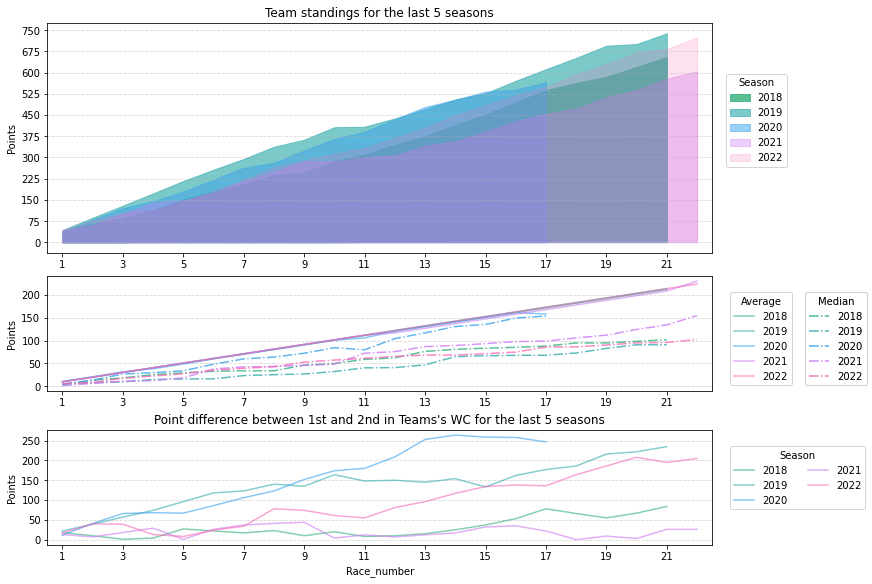

In [60]:
fig, ax = plt.subplots(3, 1, figsize = (12, 8), gridspec_kw={'height_ratios': [2, 1, 1]}, layout='constrained')

for i, season in enumerate(range(2018, 2023)):
    standings = standings_gp[season]
    leader, second, last = {'Team': [], 'Points': []}, {'Team': [], 'Points': []} , {'Team': [], 'Points': []}
    avg = []
    med = []
    for n_race in standings.Race_number.unique():
        temp_df_race = standings.query("Race_number == @n_race")
        leader['Team'].append(temp_df_race.sort_values(by = 'Team_standings', ascending = False).iloc[0].TeamName)
        leader['Points'].append(temp_df_race.sort_values(by = 'Team_standings', ascending = False).iloc[0].Team_standings)
        second['Team'].append(temp_df_race.sort_values(by = 'Team_standings', ascending = False).iloc[2].TeamName)
        second['Points'].append(temp_df_race.sort_values(by = 'Team_standings', ascending = False).iloc[2].Team_standings)
        last['Team'].append(temp_df_race.sort_values(by = 'Team_standings').iloc[0].TeamName)
        last['Points'].append(temp_df_race.sort_values(by = 'Team_standings').iloc[0].Team_standings)
        avg.append(temp_df_race.Team_standings.mean())
        med.append(temp_df_race.Team_standings.median())
        
    p1 = np.array(leader['Points'])
    p2 = np.array(second['Points'])
    p10 = np.array(last['Points'])
    
    ax[0].fill_between(standings.Race_number.unique(), p1, p10, color = c_husl[6+2*i], alpha = 0.8 - i*0.15, label = season)
    ax[1].plot(standings.Race_number.unique(), avg, color = c_husl[6+2*i], alpha = .6, label = season)
    ax[1].plot(standings.Race_number.unique(), med, color = c_husl[6+2*i], alpha = .8, linestyle = 'dashdot', label = season)
    ax[2].plot(standings.Race_number.unique(), p1-p2, color = c_husl[6+2*i], alpha = .6, label = season)
    

ax[0].set_title('Team standings for the last 5 seasons')
ax[2].set_title("Point difference between 1st and 2nd in Teams's WC for the last 5 seasons", fontsize = 12)
ax[2].set_xlabel('Race_number')

params = [(100*np.round(max(p1)/100)+75, 75), (100*np.round(max(avg)/100)+50, 50), (max(p1-p2)+50, 50)]
for i in range(3):
    ax[i].set_ylabel('Points')
    ax[i].grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .5)
    ax[i].set_xlim(0.5, 22.5, 2)
    ax[i].set_yticks(np.arange(0, params[i][0], params[i][1]))
    ax[i].set_xticks(np.arange(1, 23, 2))

ax[0].legend(title = 'Season', bbox_to_anchor=(1.12, .8))
lines = ax[1].get_lines()
legend1 = ax[1].legend([lines[i] for i in range(0, 10, 2)], [lines[i].get_label() for i in range(0, 10 ,2)], \
                       bbox_to_anchor=(1.02, .9), title = 'Average')
legend2 = ax[1].legend([lines[i] for i in range(1, 11, 2)], [lines[i].get_label() for i in range(1, 11, 2)], \
                       bbox_to_anchor=(1.24, .9), title = 'Median')
ax[1].add_artist(legend1)
ax[1].add_artist(legend2)
ax[2].legend(ncol = 2, loc = 'upper left', title = 'Season', bbox_to_anchor=(1.02, .9))

plt.show()

From the scoring perspective, the leader's score evolves differently each year, apart from a few periods of the season. The highest amount of points was achieved in 2019, despite hosting less rounds than in 2021 and 2022. 
On the contrary, 2021 is where the leading team has scored the fewest points, followed by 2018, still at a fair distance. In both of these seasons, we compared the opening stretch of the championship and found that similar scores were achieved, which suggests that a similar performance was achieved by the leading team in that stretch of the championship. 
Lastly, in spite of fewer races in 2020, the constructors' leader's score progresses in a natural way with respect to the other seasons.

Looking at the evolution of the average score, there is no difference from one season to another, as the number of teams is fixed. This is why, as we have previously performed for the drivers, we will consider the median to provide a clearer analysis of the results. Mainly, using the median enables us to monitor the performance of mid-tier teams in comparison to the top teams.
In this way, a median closer to the mean signifies that the middle zone teams are performing better, that is, scoring more points, something that can be interpreted in two ways:

1. The teams in the upper zone lose points against the rest of the teams and bottom-zone teams maintain their points (by scoring regularly) to make the championship more balanced, excluding the leading team.

2. In the upper zone, teams don't concede points, whereas teams in the bottom zone lose their points to the teams in the middle zone, resulting in more teams in the middle zone (for instance in 2019 and 2020).

A median diverging from the mean would suggest that front-running teams have a large margin and that mid-zone and low-end teams come closer to each other. To be realistic, the mid-zone would consist of few teams and the relegation zone would be large (as observed in 2022).

The gap between the two leading teams progresses differently every season, which makes it hard to imagine any sort of pattern.
We can however notice two contrasting behaviors in the first half of the season: either the deficit in points between teams can be bridged, or a crushing dominance is witnessed from the very beginning (during the first 3 or 4 races). 
During the second half of the season, the lead tends to grow, even if during certain periods it stabilizes, as for instance in 2019, from the 11th to the 14th race. However, to be stable doesn't mean to be tied. In this regard, the most leveled seasons have been 2018 and 2021, on which Mercedes prevailed respectively over Ferrari and Red Bull. Furthermore, in 2021, the front two teams swapped the lead several times throughout the season. On its part, the 2018 season seems to be done at the 14th race since Mercedes began to widen the margin from then on. We can find a contrast in the 2020 season, where Mercedes has an overwhelming dominance, establishing, in record time, the largest lead over its closest challenger for the last 5 seasons. 
Particularly outstanding is the 2022 season, where just as in the drivers' championship, a change of leadership takes place between Ferrari and Red Bull, resulting in the latter dominating at the end of the season, reaching a lead comparable to the one achieved by Mercedes in 2019.

Moving on from such basic yet key analyses when it comes to considering the context of the championship, let's first focus on the principal causes of DNFs susceptible to trigger the safety car's appearances. 

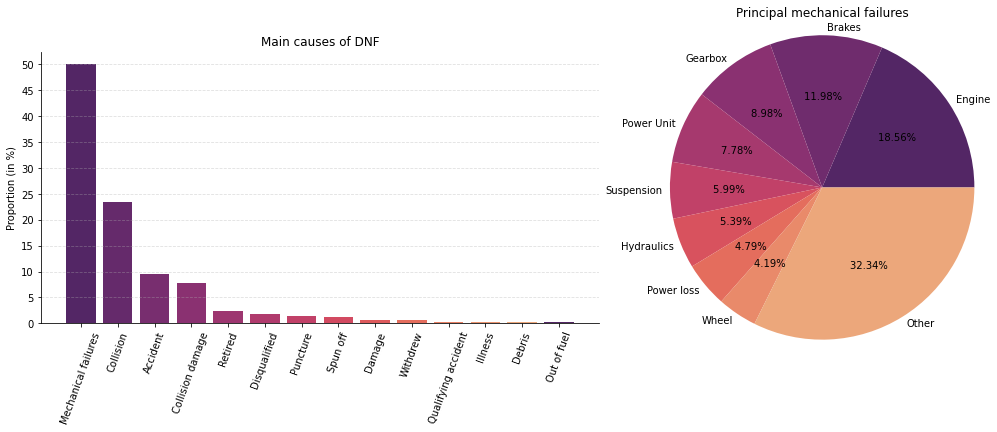

In [663]:
dnfs_dic = dict(standings_all[standings_all.Status.apply(lambda x: x not in ['Finished', '+1 lap', '+2 laps', '+1 Lap']+\
        [f'+{i} Laps' for i in range(2, 9)])].Status.value_counts())

total_dnfs = sum(dnfs_dic.values())
for key, val in dnfs_dic.items():
    dnfs_dic[key] = 100 * val/total_dnfs
    
to_keep = ['Collision', 'Accident', 'Collision damage', 'Retired', 'Disqualified', 'Puncture', 'Spun off', 'Damage', 'Withdrew',\
'Qualifying accident', 'Illness', 'Debris', 'Out of fuel']

dnfs_dic_filtered = {'Mechanical failures': 0}
for key, val in dnfs_dic.items():
    if key in to_keep:
        dnfs_dic_filtered[key] = val
    else:
        dnfs_dic_filtered['Mechanical failures'] += val
    
fig, ax = plt.subplots(1,2, figsize = (16.5, 5), gridspec_kw={'width_ratios': [2, 1]})
# Left figure
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].bar(dnfs_dic_filtered.keys(), dnfs_dic_filtered.values(), color = c_flare[::-2])
ax[0].tick_params(axis='x', rotation=70)
ax[0].set_title('Main causes of DNF')
ax[0].set_ylabel('Proportion (in %)')
ax[0].set_yticks(100*np.arange(0, 0.55, 0.05))
ax[0].grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .4)

# Right figure
ax[1].pie([val for key, val in dnfs_dic.items() if key not in to_keep and val > 2] + \
          [sum([val for key, val in dnfs_dic.items() if key not in to_keep and val <= 2])], \
          labels=[key for key, val in dnfs_dic.items() if key not in to_keep and val > 2] + ['Other'], \
        rotatelabels = False, colors = c_flare[::-3], labeldistance=1.05, radius = 1.4, autopct= lambda p : '{:.2f}% '.format(p) if p > 4 else '')

ax[1].set_title('Principal mechanical failures', pad=35)


plt.show()

From this chart, it is apparent that the most frequent cause (50%) of DNFs are mechanical failures affecting the vehicle.
Next comes, at over 30%, the crashes between drivers and the ensuing damage, and then the drivers' accidents, accounting for 10% of the DNFs. Engine and power unit malfunctions, along with power loss, constitute about 31% of the DNFs involving mechanical failures, thus showcasing how crucial are all power components for reliability. Note that the elements causing mechanical breakdowns, all except for the wheels, can't be substituted during a pitstop and they constitute an essential part of the car.

Following the quantitative analysis, it is worth looking at the situation as follows: since teams either tell their drivers to withdraw as soon as they detect any major malfunction or give directions to pull off the track, it is reasonable to believe that despite accounting for 50% of all DNFs, mechanical failures might not necessarily be the primary cause of safety car deployments. On the other hand, the seriousness of a collision or a crash plays the most important role in keeping the car going in the race but is very difficult for us to estimate with the data we have at hand. So we would venture to suggest that they play a bigger role (in relative terms) than mechanical failures in the appearance of the safety car.

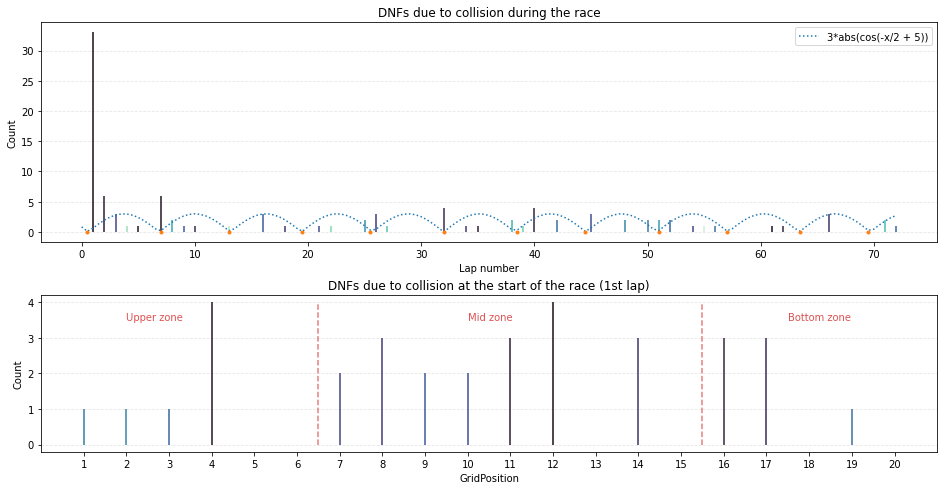

In [836]:
dnf_laps_dic = dict(standings_all[standings_all.Status.apply(lambda x: x not in ['Finished', '+1 lap', '+2 laps', '+1 Lap']+\
        [f'+{i} Laps' for i in range(2, 9)])].query("Status in ['Collision', 'Collision damage']").Laps_completed.value_counts())

collision_dic = dict(standings_all[standings_all.Status.apply(lambda x: x not in ['Finished', '+1 lap', '+2 laps', '+1 Lap']+\
        [f'+{i} Laps' for i in range(2, 9)])].query("Status in ['Collision', 'Collision damage'] & Laps_completed == 0").GridPosition.value_counts())

fig, ax = plt.subplots(2, 1, figsize = (13, 6.7), gridspec_kw={'height_ratios': [1.4, 1]}, layout='constrained')

# Top figure
sup = df_.Total_laps.max()
ax[0].vlines(np.array(list(dnf_laps_dic.keys())) + 1, 0, dnf_laps_dic.values(), color = c_mako)
ax[0].set_title('DNFs due to collision during the race')
ax[0].set_xlabel('Lap number')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(0, sup, 10))
ax[0].grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .3)
ax[0].plot(np.arange(0, 72.5, 0.5), [3*abs(np.cos(-x/2 + 5)) for x in np.arange(0, 72.5, 0.5)], linestyle = ':', \
                       label = r"3*abs(cos(-x/2 + 5))")
ax[0].plot(np.array([ 0.5,  7. , 13. , 19.5, 25.5, 32. , 38.5, 44.5, 51. , 57. , 63.5, 69.5]), [0]*12, linestyle = 'None', marker = '.')
ax[0].legend()

# Bottom figure
sup = max(collision_dic.values())
ax[1].vlines(list(collision_dic.keys()), 0, collision_dic.values(), color = c_mako)
ax[1].plot([6.5, 6.5], [0, sup], color = 'tab:red', linestyle = 'dashed', alpha = .6)
ax[1].plot([15.5, 15.5], [0, sup], color = 'tab:red', linestyle = 'dashed', alpha = .6)
ax[1].text(x = 2, y = sup - 0.5, s = 'Upper zone', color = 'tab:red', alpha = .8)
ax[1].text(x = 10, y = sup - 0.5, s = 'Mid zone', color = 'tab:red', alpha = .8)
ax[1].text(x = 17.5, y = sup - 0.5, s = 'Bottom zone', color = 'tab:red', alpha = .8)
ax[1].set_title('DNFs due to collision at the start of the race (1st lap)')
ax[1].set_xlabel('GridPosition')
ax[1].set_ylabel('Count')
ax[1].set_xticks(np.arange(1, 21))
ax[1].set_xlim(0, 21)
ax[1].set_yticks(np.arange(sup + 1))
ax[1].grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .3)

plt.show()

We have seen that collisions are especially relevant among DNFs and in the eventual release of a safety car. 
The chart above that crashes happen at the very opening of the race, on the first lap, so it is particularly convenient to identify the drivers' grid positions in order to better define the likelihood of those who might be involved in a collision at the beginning of a race.
In addition, we could sense a possible pattern indicating the timing of the collisions during the race. In this way, we could explore it in more depth if necessary.
Looking at the collisions on the opening lap of the race, we notice that a large majority of collisions take place in the middle section of the grid, while the front runners are caught up in a few sporadic collisions.

This makes it pertinent to observe the average qualifying spot of each driver and, when compared to the average finishing place, we could also estimate, when useful, the propensity of each driver to suffer a crash at the start of the race, gain an insight into the individual performance of the drivers and/or cars during qualifying and actual races, plus a glimpse onto the differing levels of team performance in the upper, mid- and lower zones.

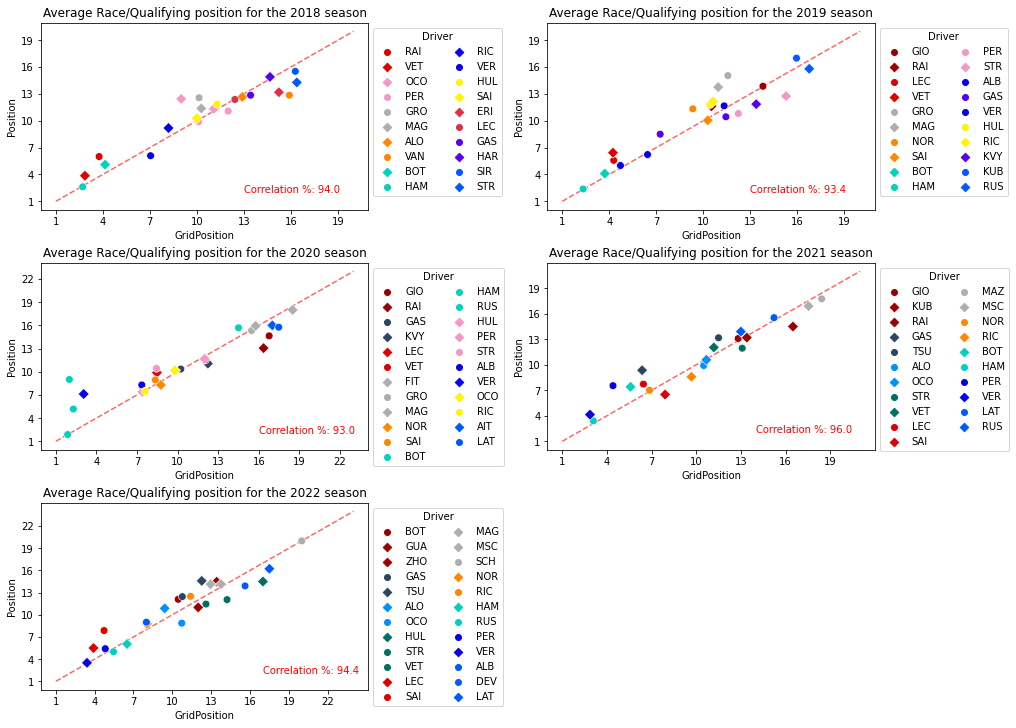

In [76]:
fig, ax = plt.subplots(3, 2, figsize = (14, 10), layout='constrained')
ax = ax.flatten()
ax[-1].set_visible(False)

for i, season in enumerate(range(2018, 2023)):
    colors = {x[1]: c_team[x[0]] for x in standings_gp[season][['TeamName', 'Abbreviation']].drop_duplicates().values}
    marker = {x: 'D' for x in standings_gp[season][['TeamName', 'Abbreviation']].drop_duplicates().\
                                                                                      sort_values(by = 'TeamName').values[::2,1]}
    marker = marker|{x: 'o' for x in standings_gp[season][['TeamName', 'Abbreviation']].drop_duplicates()\
                                                                                     .sort_values(by = 'TeamName').values[1::2,1]}
    
    sns.scatterplot(standings_gp[season].groupby(['TeamName', 'Abbreviation']).mean(), x = 'GridPosition', y = 'Position', \
        hue = 'Abbreviation', style = 'Abbreviation', ax = ax[i], palette = colors, markers = marker, s = 60)
    
    n_drivers = len(standings_gp[season].Abbreviation.unique())
    corr_coef = np.round(standings_gp[season].groupby(['TeamName', 'Abbreviation']).mean()\
                                                                 [['Position', 'GridPosition']].corr().values[0,1], 3)
    ax[i].plot(np.arange(1, n_drivers + 1), np.arange(1, n_drivers + 1), linestyle = 'dashed', color = 'red', zorder = 0, alpha = .6) 
    ax[i].text(x = n_drivers-7, y = 2, s = "Correlation %: {:.1f}".format(100*corr_coef), color = 'red')
    ax[i].set_title(f'Average Race/Qualifying position for the {season} season')
    ax[i].set_xticks(range(1, n_drivers, 3))
    ax[i].set_yticks(range(1, n_drivers, 3))
    ax[i].legend(ncol = 2, bbox_to_anchor = (1, 1), title = 'Driver')
    
plt.show()

*Firstly, we must stress that in some teams, there are shown 3 drivers, due to the participation of the reserve drivers in some events. Firstly, we must stress that in some teams, there are shown 3 drivers, due to the participation of the reserve drivers in some events. In 2020, Russell, who drives for Williams, replaced Hamilton (Mercedes) for the Sakhir GP, and that is why he is listed twice in the chart under this color, but we understand that his average position throughout the season corresponds to his performance for Williams.*

*Secondly, going into 2019, there was a mid-season switch of drivers between Red Bull Racing and its subsidiary Toro Rosso. This is why Gasly and Albon are featured in Red Bull, however you can distinguish Gasly by the color of Toro Rosso. In addition, each driver's average positions at Red Bull and Toro Rosso have also been represented.*

It is apparent from the first observation that there is a strong correlation between the average starting and finishing positions, which doesn't occur when we use the (raw) starting and finishing positions.  

Considering the earlier figure showing the amount of collisions at the start of the race, there is a tendency for Mercedes drivers to be less vulnerable to early race collisions, as is the case, in a less apparent way, for Red Bull and Ferrari drivers. On the other hand, Racing Point (now Aston Martin), McLaren, Renault (Alpine), and recently Alfa Romeo, have higher odds of either hitting or being hit at the start of the race. 
It is understood that collisions during the race usually occur between drivers with similar racing performances. Therefore, by taking into account the ranking and the average position, we will be able to define a metric for assessing the similarity level between drivers to improve the accuracy of the predictions. Note that such metric is not aimed at comparing two drivers who have disparate ambitions, i.e. we are not willing to match a driver who competes for podiums and victories with a driver who struggles to score points.

In terms of performance, in this representation we can easily recognize the superiority of the teams in the upper zone, but also the teams trailing at the bottom. Nonetheless in some of these charts, for instance when we look at 2018, 2019 or even 2022, it's actually difficult to draw the borderline between the mid-zone and bottom-zone teams.
Moreover, and as mentioned earlier, in this figure we can determine how teams do in qualifying, and how they behave during the race, and more specifically, how drivers perform, i.e. whether they do better on a single lap or in the race.

As we saw earlier, Collisions and incidents represent a significant portion of the DNFs. Still, this doesn't tell us the whole picture, as mechanical breakdowns cause the majority of withdrawals, despite they don't all translate into the deployment of a safety car. Accordingly, we will gather the individual DNFs for each driver and in each season, plus the overall DNFs for each team, so that we establish where the driver's and team's "fault" lie in the DNFs. In other words, a driver with serveral withrawals, that make up a very large percentage of the team is judged differently from a driver with a similar ratio to his teammate. 

In addition, year-to-year variation in the frequency of DNFs for each driver might be a useful way to establish the risk or tendency for a driver to suffer a DNF, as we will aim to do, taking special attention to prevent introducing a significant bias in the algorithm. 

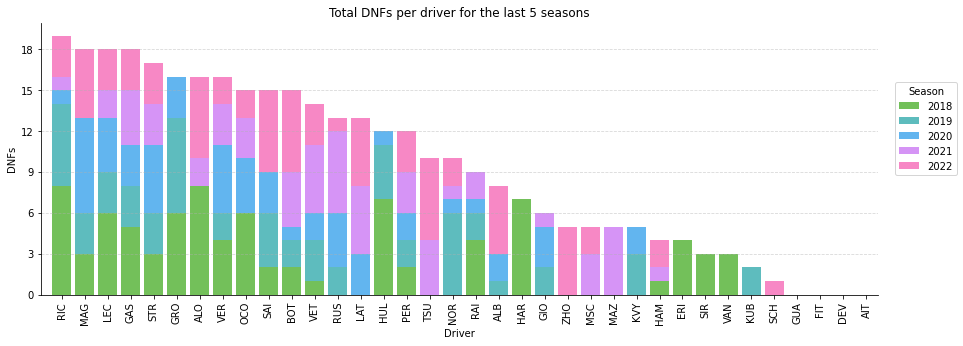

In [700]:
# sorting by DNF 
all_drivers = standings_all.groupby(['Abbreviation']).DNF.sum().sort_values(ascending = False).index 
s1 = standings_all.groupby(['Abbreviation','Season']).sum().sort_values(by = 'DNF', ascending = False)
s2 = s1.reindex(index = all_drivers, level = 0)[['DNF']]

fig, ax = plt.subplots(figsize = (15, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
s2.unstack().plot.bar(stacked = True, legend = False, color = [c_husl[5]]+[c_husl[i] for i in range(8, 16, 2)], \
    alpha = .8,  width = 0.8, ax = ax, yticks = np.arange(0, 20, 3), xlabel = 'Driver', ylabel = 'DNFs', \
        title = 'Total DNFs per driver for the last 5 seasons')

plt.xlim(-.9, len(all_drivers)-.5)
plt.legend(list(range(2018, 2023)), title = 'Season', bbox_to_anchor = (1.1, .8))
plt.grid(b=True, which='both', axis='y', linestyle='dashed', alpha = .5)
plt.show()

In [866]:
layout = go.Layout(title=go.layout.Title(text = "Total DNFs per team for the last 5 seasons"), \
                    xaxis=dict(title = "TeamName"), yaxis=dict(title = "DNFs"))

fig = go.Figure(layout=layout)
colors_ = [c_husl.as_hex()[5]]+[c_husl.as_hex()[i] for i in range(8, 16, 2)] # Convert to HEX
list_teams = ['Ferrari', 'Mercedes', 'Red Bull Racing', 'McLaren', 'Renault', 'Force India', 'Sauber', 'Williams', 'Toro Rosso',\
                'Haas F1 Team', 'Racing Point', 'Alfa Romeo', 'AlphaTauri', 'Aston Martin', 'Alpine']

for i, season in enumerate(range(2018, 2023)):
    df_info = standings_gp[season]
    #mean_dnf = df_info.DNF.sum()/len(set(df_info.TeamName))
    teams_year = df_info.iloc[-20:].sort_values(by = 'Team_standings', ascending = False).TeamName.unique()
    rankings = [np.where(teams_year == x)[0][0] + 1 if x in teams_year else " " for x in list_teams]
    fig.add_trace(go.Histogram(histfunc="sum", name = season, x = df_info.TeamName, y = df_info.DNF, opacity = 0.8, \
                  text = rankings, marker_color = colors_[i]))
    
fig.add_annotation(dict(font=dict(size=12), x=13.5, y=11,text="- Ranking", showarrow=False))
    
fig.update_layout(autosize=False, width=980, height=500)
fig.update_traces(textposition='outside', textfont_size=10)


fig.show()

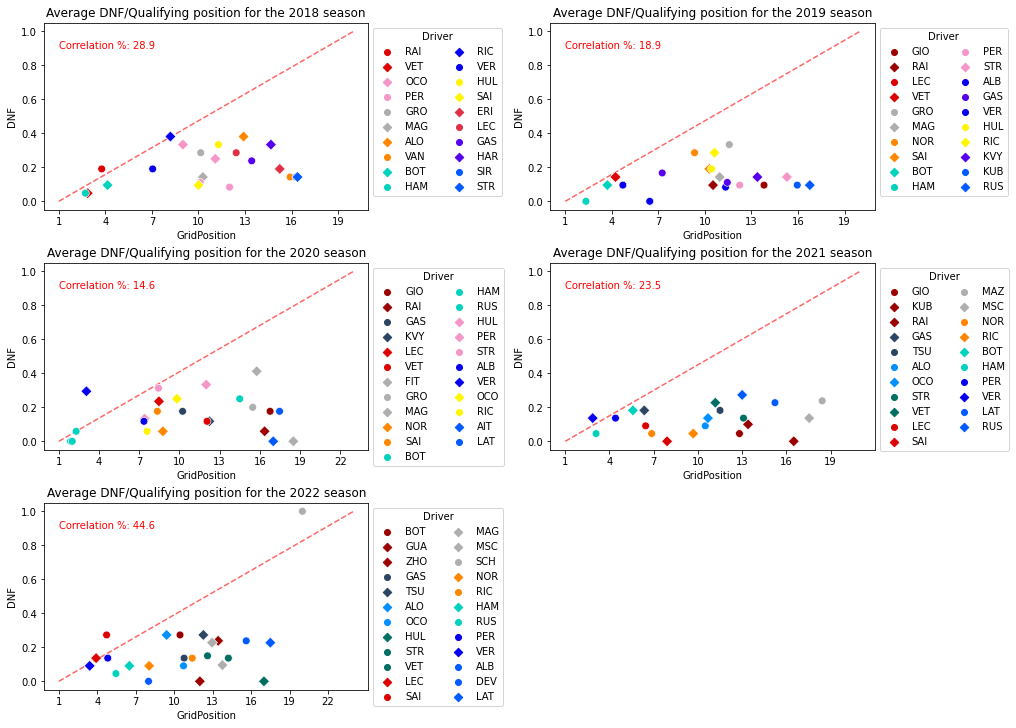

In [831]:
fig, ax = plt.subplots(3, 2, figsize = (14, 10), layout='constrained')
ax = ax.flatten()
ax[-1].set_visible(False)

for i, season in enumerate(range(2018, 2023)):
    colors = {x[1]: c_team[x[0]] for x in standings_gp[season][['TeamName', 'Abbreviation']].drop_duplicates().values}
    marker = {x: 'D' for x in standings_gp[season][['TeamName', 'Abbreviation']].drop_duplicates().\
                                                                                      sort_values(by = 'TeamName').values[::2,1]}
    marker = marker|{x: 'o' for x in standings_gp[season][['TeamName', 'Abbreviation']].drop_duplicates()\
                                                                                     .sort_values(by = 'TeamName').values[1::2,1]}
    
    sns.scatterplot(standings_gp[season].groupby(['TeamName', 'Abbreviation']).mean(), x = 'GridPosition', y = 'DNF', \
        hue = 'Abbreviation', style = 'Abbreviation', ax = ax[i], palette = colors, markers = marker, s = 60)
    
    n_drivers = len(standings_gp[season].Abbreviation.unique())
    corr_coef = np.round(standings_gp[season].groupby(['TeamName', 'Abbreviation']).mean()\
                                                                 [['DNF', 'GridPosition']].corr().values[0,1], 3)
    ax[i].plot(np.arange(1, n_drivers + 1), np.linspace(0, 1, n_drivers), linestyle = 'dashed', color = 'red', zorder = 0, alpha = .6) 
    ax[i].text(x = 1, y = 0.9, s = "Correlation %: {:.1f}".format(100*corr_coef), color = 'red')
    ax[i].set_title(f'Average DNF/Qualifying position for the {season} season')
    ax[i].set_xticks(range(1, n_drivers, 3))
    #ax[i].set_yticks(range(1, n_drivers, 3))
    ax[i].legend(ncol = 2, bbox_to_anchor = (1, 1), title = 'Driver')
    
plt.show()